In [75]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import gc
import time

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns

from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
train_user = pd.read_pickle('after_reducion/train_user.pkl')
test_user = pd.read_pickle('after_reducion/test_user.pkl')

In [ ]:
'''
    处理缺失值：city name 和 county name用未知代替
    float16不够用，得用float64
    
    这里没有都话费的缺失值进行处理，因为考虑到，如果用所有人每个月的平均话费来填补。好像没什么意义，
                                如果用每个人几个月来的话费进行填补，可能又多此一举
                                如果考虑用每个月的众数来填补，那么会发现起前几个月的话费都是1，没什么意义
                                so 考虑观察nan和非nan情况下话费的每个号码话费的平均值
    
    可能的特征：
        1. 话费为负数可能代表欠费, 将之转为正数，并添加特征是否欠费.
            首先因为欠费的人数极少，而且进一步观察，发现欠费人都不是诈骗电话 -----> 可能可以用来证明是正常电话
        
        2. 可以添加特征，是否为NAN 和  平均话费是否较高
            分析发现，为NAN时诈骗电话概率较高，平均话费高时，诈骗电话概率较高.
            总体来说，诈骗电话话费更高
            特征: is_null 和  mean_arpu（test数据里是arpu_202004）
            
        3. 观察mean_arpu时发现，当地方数据和话费数据全为NAN时，都是诈骗电话（主要考虑话费）
            所以可以添加另一个特征，is_all_null（test 里面就是is_null）
        
        4. 可能的特征，idcard_cnt == 0的更有可能是诈骗电话，可以存起来.
            idcard_cnt_equal_zero
        
        5. idcard_cnt的平均值，idcard_cnt_small_two 从平均值可以看出来，分界线是2，低于2的一般为正常电话。
    
    
'''

In [170]:
train_user.isnull().sum()

phone_no_m        0
city_name         0
county_name       0
idcard_cnt        0
arpu_201908    1791
arpu_201909    1641
arpu_201910    1436
arpu_201911    1026
arpu_201912     854
arpu_202001     957
arpu_202002     945
arpu_202003     737
label             0
is_arrears        0
mean_arpu       174
dtype: int64

In [171]:
test_user.isnull().sum()

phone_no_m       0
city_name        0
county_name      0
idcard_cnt       0
arpu_202004    176
is_arrears       0
dtype: int64

In [7]:
train_user['city_name'] = train_user['city_name'].astype('object').fillna('未知').astype('category')
train_user['county_name'] = train_user['county_name'].astype('object').fillna('未知').astype('category')

test_user['city_name'] = test_user['city_name'].astype('object').fillna('未知').astype('category')
test_user['county_name'] = test_user['county_name'].astype('object').fillna('未知').astype('category')

In [78]:
# 清理负数
def clear_minus(a,b,c,d,e,f,g,h):
    if a < 0 or b <0 or c < 0 or d < 0 or e < 0 or f < 0 or g < 0 or h < 0:
        return 1
    else:
        return 0
    

In [81]:
train_user['is_arrears'] = 0
train_user['is_arrears'] = train_user.parallel_apply(lambda x:clear_minus(x['arpu_201908'],x['arpu_201909'],
                                                                          x['arpu_201910'],x['arpu_201911'],
                                                                          x['arpu_201912'],x['arpu_202001'],
                                                                          x['arpu_202002'],x['arpu_202003']),axis=1)
test_user['is_arrears'] = 0
test_user['is_arrears'] = test_user['arpu_202004'].apply(lambda x:1 if x < 0 else 0)

In [87]:
train_user['arpu_201908'] = train_user['arpu_201908'].abs() 
train_user['arpu_201909'] = train_user['arpu_201909'].abs() 
train_user['arpu_201910'] = train_user['arpu_201910'].abs() 
train_user['arpu_201911'] = train_user['arpu_201911'].abs() 
train_user['arpu_201912'] = train_user['arpu_201912'].abs() 
train_user['arpu_202001'] = train_user['arpu_202001'].abs() 
train_user['arpu_202002'] = train_user['arpu_202002'].abs() 
train_user['arpu_202003'] = train_user['arpu_202003'].abs() 
test_user['arpu_202004'] = test_user['arpu_202004'].abs() 

In [219]:
# float16不够用，得用float64
# 这个是每个月的平均费用，按照这个题目，月份似乎不能作为依据，因为要用前面的月份数据预测后面月份的。但还是打印出来吧
train_user['arpu_201908'] = train_user['arpu_201908'].astype('float')
train_user['arpu_201909'] = train_user['arpu_201909'].astype('float')
train_user['arpu_201910'] = train_user['arpu_201910'].astype('float')
train_user['arpu_201911'] = train_user['arpu_201911'].astype('float')
train_user['arpu_201912'] = train_user['arpu_201912'].astype('float')
train_user['arpu_202001'] = train_user['arpu_202001'].astype('float')
train_user['arpu_202002'] = train_user['arpu_202002'].astype('float')
train_user['arpu_202003'] = train_user['arpu_202003'].astype('float')
test_user['arpu_202004'] = test_user['arpu_202004'].astype('float')
arpu_describe = train_user.describe()[['arpu_201908',
       'arpu_201909', 'arpu_201910', 'arpu_201911', 'arpu_201912',
       'arpu_202001', 'arpu_202002', 'arpu_202003']]
train_user.describe()

,idcard_cnt,arpu_201908,arpu_201909,arpu_201910,arpu_201911,arpu_201912,arpu_202001,arpu_202002,arpu_202003,label,is_arrears,mean_arpu,is_null,is_all_null
count,6106.000000,4315.000000,4465.000000,4670.000000,5080.000000,5252.000000,5149.000000,5161.000000,5369.000000,6106.000000,6106.000000,5932.000000,6106.000000,6106.000000
mean,2.071896,60.360384,58.779904,59.753124,64.608245,70.568912,59.490727,58.612965,64.294162,0.321323,0.001146,66.535637,0.304291,0.028497
std,1.329156,62.839332,63.026827,70.519587,87.771445,115.368201,75.448351,177.211136,130.291484,0.467023,0.033842,90.238313,0.460144,0.166400
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,14.000000,13.000000,13.328125,14.000000,15.126953,16.375000,14.062500,15.296875,0.000000,0.000000,18.265625,0.000000,0.000000
50%,2.000000,41.000000,39.593750,39.000000,41.046875,40.000000,39.000000,34.000000,39.000000,0.000000,0.000000,43.186523,0.000000,0.000000
75%,3.000000,89.000000,82.937500,86.265625,91.140625,92.015625,77.000000,73.000000,77.625000,1.000000,0.000000,85.263672,1.000000,0.000000
max,13.000000,506.500000,773.500000,1291.000000,1923.000000,1859.000000,1296.000000,11848.000000,4560.000000,1.000000,1.000000,2406.534375,1.000000,1.000000


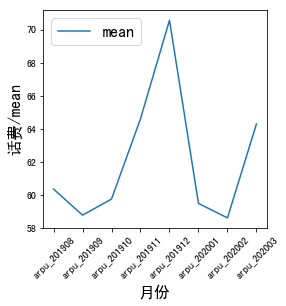

In [91]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
sns.lineplot(x = arpu_describe.T.reset_index()['index'],y=arpu_describe.T.reset_index()['mean'],ax=ax,label='mean')
ax.set_xlabel('月份',fontsize=16)
ax.set_ylabel('话费/mean',fontsize=16)
plt.xticks(rotation=45)
plt.legend(loc='best',prop={'size':16})
plt.show()

In [220]:
# 前几个月的话费平均值
train_user['mean_arpu'] = train_user[['arpu_201908',
       'arpu_201909', 'arpu_201910', 'arpu_201911', 'arpu_201912',
       'arpu_202001', 'arpu_202002', 'arpu_202003']].mean(axis=1)
# test里面因为还有一个月的话费，所以就拿它了
test_user['mean_arpu'] = test_user['arpu_202004']

In [141]:
print('有Nan的情况下：')
print(train_user[train_user.isnull().T.any()].label.value_counts())
print('没有Nan的情况下：')
print(train_user[train_user.notnull().T.all()].label.value_counts())

有Nan的情况下：
1    1429
0     429
Name: label, dtype: int64
没有Nan的情况下：
0    3715
1     533
Name: label, dtype: int64


In [131]:
print('诈骗电话的平均话费：')
print(train_user[train_user['label']==1]['mean_arpu'].mean())
print('正常电话电话的平均话费：')
print(train_user[train_user['label']==0]['mean_arpu'].mean())

诈骗电话的平均话费：
93.17265372718754
正常电话电话的平均话费：
55.042638713530174


In [252]:
# 观察 NAN 和 非NAN 情况下平均话费
a = train_user[train_user.isnull().T.any()].reset_index(drop=True)
b = pd.DataFrame(a[a['label'] == 1]['mean_arpu']).describe()
b = pd.concat([b,pd.DataFrame(a[a['label'] == 0]['mean_arpu']).describe()],axis=1)

a = train_user[train_user.notnull().T.all()].reset_index(drop=True)
b = pd.concat([b,pd.DataFrame(a[a['label'] == 1]['mean_arpu']).describe()],axis=1)
b = pd.concat([b,pd.DataFrame(a[a['label'] == 0]['mean_arpu']).describe()],axis=1)
b = b.T
b['is_nan'] = ['NAN','NAN','NOT NAN','NOT NAN']
b['is_normal'] = ['fraud','normal','fraud','normal']

In [261]:
b

,count,mean,std,min,25%,50%,75%,max,is_nan,is_normal
mean_arpu,1429.0,97.395560,146.361035,1.0,30.729167,56.937500,100.000000,2406.534375,NAN,fraud
mean_arpu,429.0,29.498557,31.393902,1.0,8.859375,18.960938,39.732813,199.087891,NAN,normal
mean_arpu,533.0,84.079642,70.694870,1.0,27.596680,70.062500,112.976562,385.500000,NOT NAN,fraud
mean_arpu,3715.0,57.992413,57.864371,1.0,15.755859,40.031250,81.753906,544.375000,NOT NAN,normal


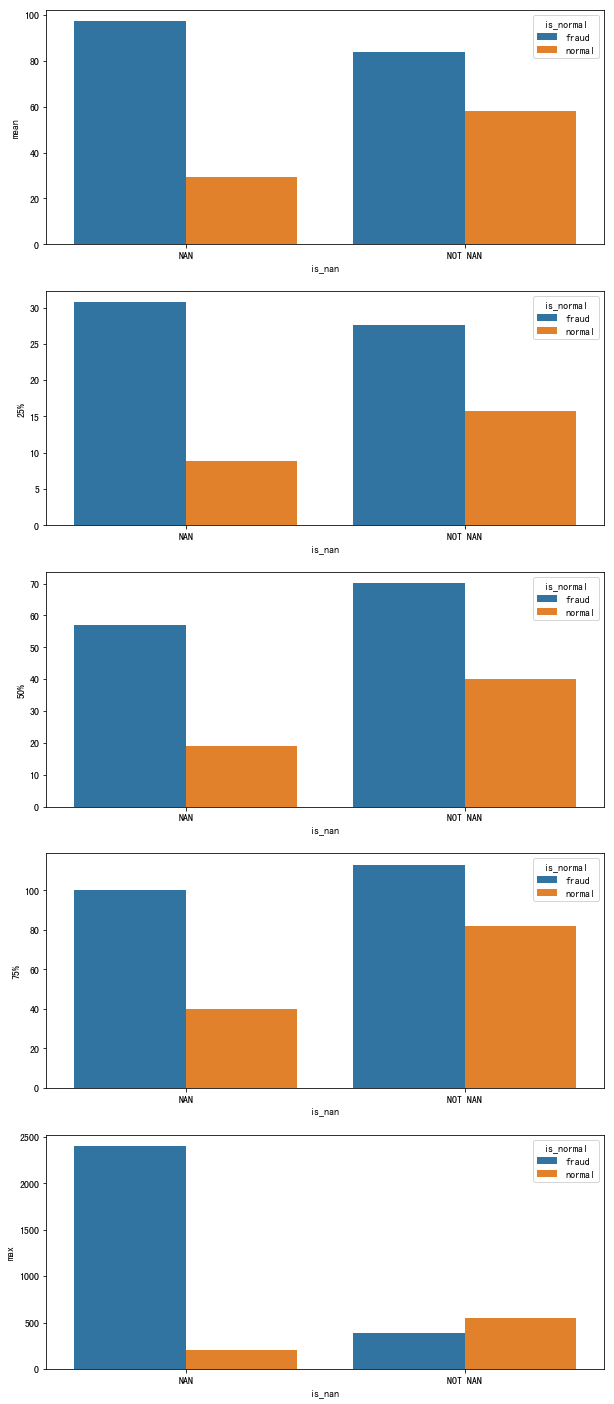

In [260]:
# 观察 NAN 和 非NAN 情况下平均话费
fig,ax = plt.subplots(5,1,figsize=(10,25))
sns.barplot(x=b['is_nan'],y=b['mean'],hue=b['is_normal'],ax=ax[0])
sns.barplot(x=b['is_nan'],y=b['25%'],hue=b['is_normal'],ax=ax[1])
sns.barplot(x=b['is_nan'],y=b['50%'],hue=b['is_normal'],ax=ax[2])
sns.barplot(x=b['is_nan'],y=b['75%'],hue=b['is_normal'],ax=ax[3])
sns.barplot(x=b['is_nan'],y=b['max'],hue=b['is_normal'],ax=ax[4])
plt.show()

In [178]:
# 观察train_user中mean_arpu平均话费缺失值情况，在test_user中是arpu_202004
# 这里的city_name 和county_name 是人为补充未知上去的
train_user[train_user['mean_arpu'].isnull()]

,phone_no_m,city_name,county_name,idcard_cnt,arpu_201908,arpu_201909,arpu_201910,arpu_201911,arpu_201912,arpu_202001,arpu_202002,arpu_202003,label,is_arrears,mean_arpu
75,6b4999280b1f69a44e4e4b4d624e7d2055a1a407b449eb...,未知,未知,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN
104,e56bde9f85fe201fe546cd83b43be86f89f562f271aaec...,未知,未知,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN
130,35e64a4d264a1ddee0d45079ee90fad25dc8de93430696...,未知,未知,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN
157,863b82930414fce2972e159bb82f213a580d0e08523654...,未知,未知,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN
176,e6e7afe093476b008424cc6d7455c2f64f8619be09e4de...,未知,未知,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,53e25caa6bb68099bfcb559ec9a6c093992ba4ad9cf922...,未知,未知,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN
6028,479e60294b0ddbefd5ef6f8aa6ffc1175200827b93fe7c...,未知,未知,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN
6076,b3b3d66fbf8d3883614cbeacbb7c3393e99295b4319a8a...,未知,未知,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN
6094,068eebee8aa3ecabc6a30622bf14141d398eda8c236a31...,未知,未知,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN


In [227]:
train_user['is_null'] = train_user.isnull().T.any().apply(lambda x:1 if x else 0)
train_user['is_all_null'] = train_user['mean_arpu'].isnull().apply(lambda x:1 if x else 0 )
train_user['mean_arpu'].fillna(100,inplace=True) # 因为label一定是等于1的，而诈骗电话的平均话费90多，那么就用100来代替

In [224]:
test_user['is_null'] = test_user.isnull().T.any().apply(lambda x:1 if x else 0)
test_user['is_all_null'] = test_user.isnull().T.any().apply(lambda x:1 if x else 0)
test_user['mean_arpu'].fillna(100,inplace=True)

In [232]:
# 发现有的身份证旗下没有电话号码，是异常值
train_user.idcard_cnt.value_counts()

1     2785
2     1485
3      809
4      495
5      466
0       46
6       12
13       4
10       2
7        1
8        1
Name: idcard_cnt, dtype: int64

In [262]:
#号码数目为0的，更容易是诈骗电话
train_user[train_user['idcard_cnt'] == 0].label.value_counts()

1    41
0     5
Name: label, dtype: int64

In [230]:
# 观察身份证
train_user.groupby('label').mean()

,idcard_cnt,arpu_201908,arpu_201909,arpu_201910,arpu_201911,arpu_201912,arpu_202001,arpu_202002,arpu_202003,is_arrears,mean_arpu,is_null,is_all_null
label,,,,,,,,,,,,,
0,1.705598,58.325675,57.245984,57.628403,57.004657,57.486461,56.248134,54.083694,55.060553,0.001689,55.042639,0.103523,0.000000
1,2.845566,73.007561,67.100589,68.955397,88.129738,110.998171,71.049650,75.010793,95.530140,0.000000,93.778137,0.728338,0.088685


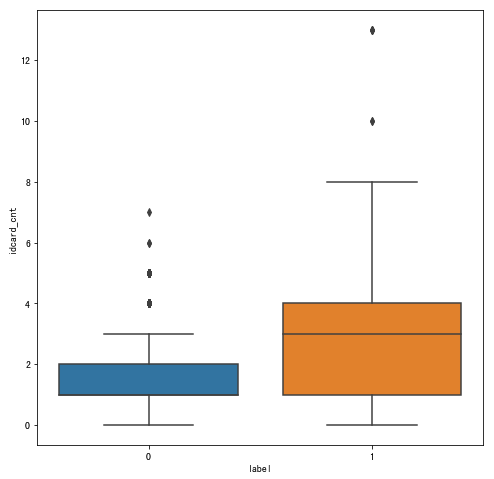

In [263]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
sns.boxplot(x=train_user['label'],y=train_user['idcard_cnt'],ax=ax)
plt.show()

In [269]:
train_user.to_pickle('after_EDA/train_user.pkl')
test_user.to_pickle('after_EDA/test_user.pkl')

In [ ]:
可能需要用到聚类分析，留着

In [115]:
del a,b
gc.collect()

phone_no_m     6106
city_name      6106
county_name    6106
idcard_cnt     6106
arpu_201908    4315
arpu_201909    4465
arpu_201910    4670
arpu_201911    5080
arpu_201912    5252
arpu_202001    5149
arpu_202002    5161
arpu_202003    5369
label          6106
is_arrears     6106
dtype: int64

In [9]:
test_user.isnull().sum()

phone_no_m       0
city_name        0
county_name      0
idcard_cnt       0
arpu_202004    176
dtype: int64